In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent   # one level up
sys.path.insert(0, str(project_root))
#Import the tools
from src.parse_atlas import parser
from src.calculations import physics_calcs, combinatorics
from src.im_calculator import im_calculator
import math, awkward as ak, numpy as np
import atlasopenmagic as atom
import matplotlib.pyplot as plt
import os
import uproot
import logging

from typing import Dict, List, Optional, Tuple


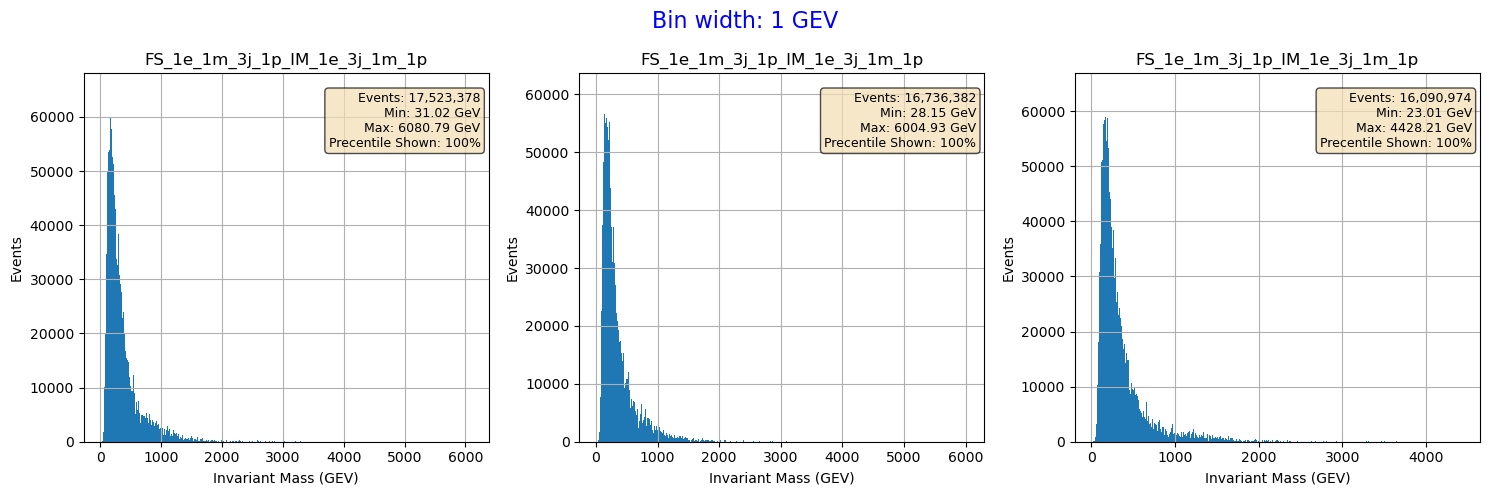

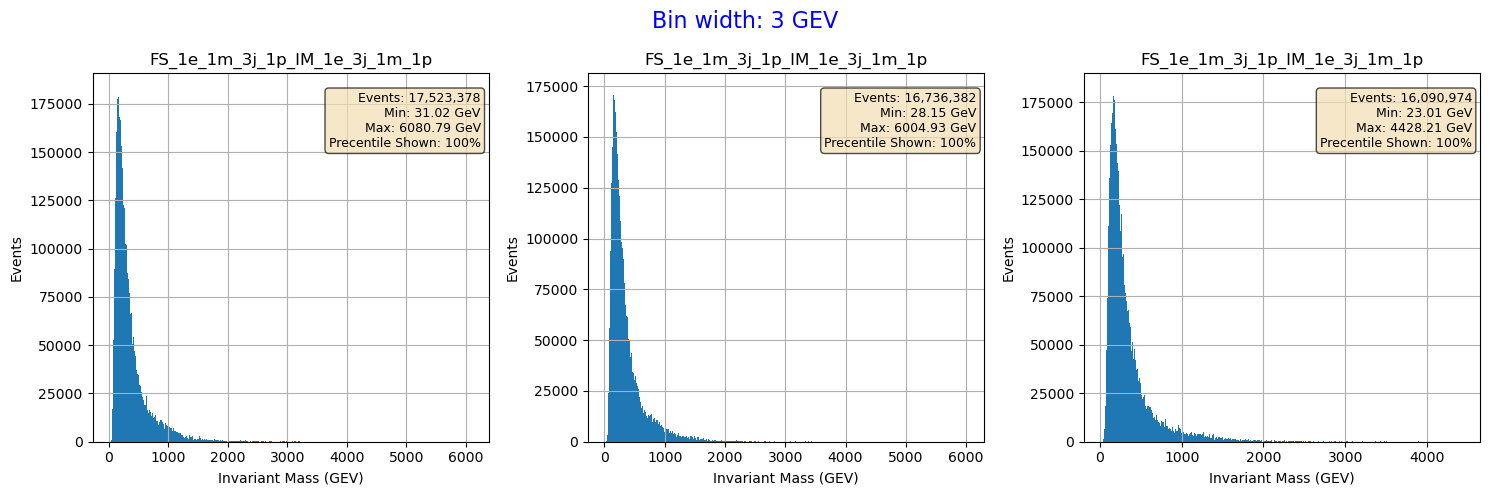

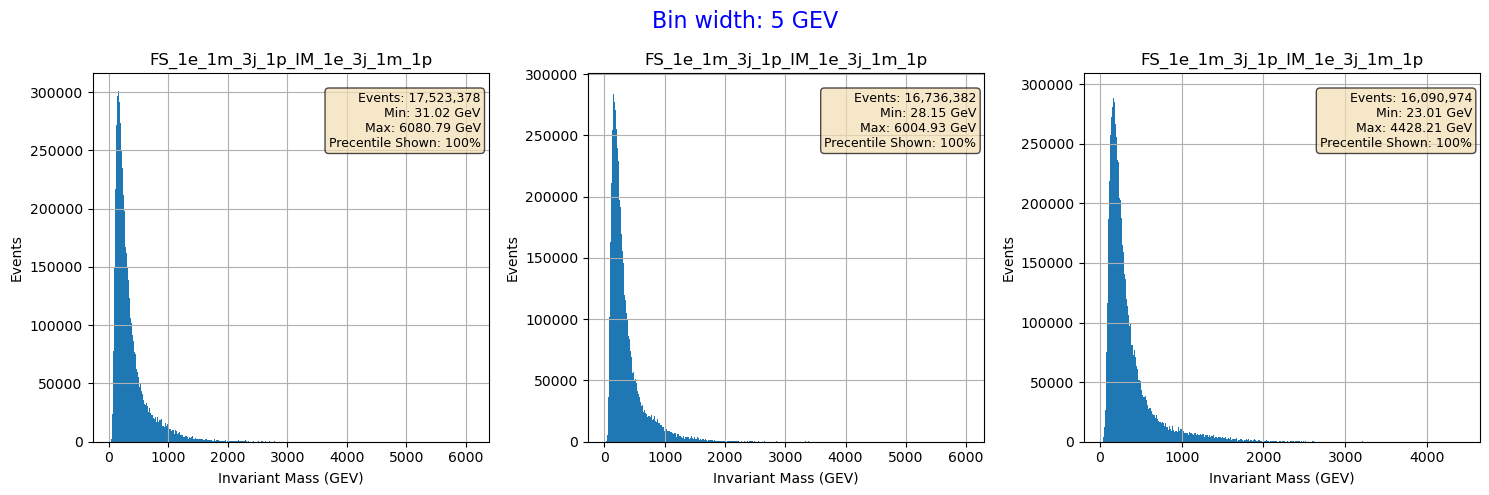

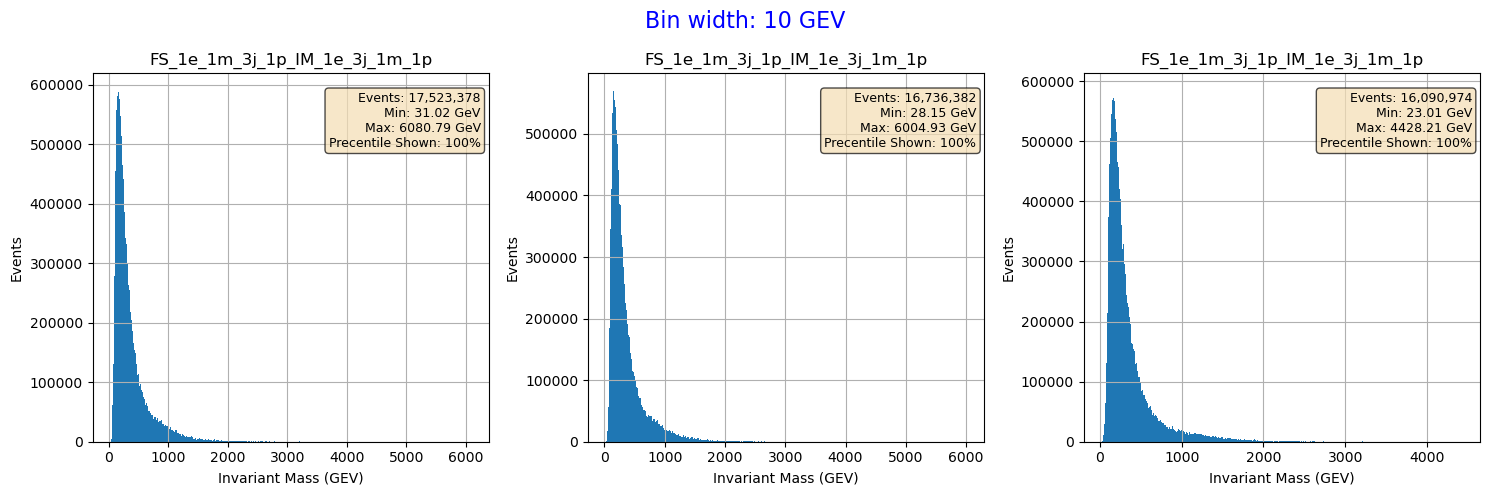

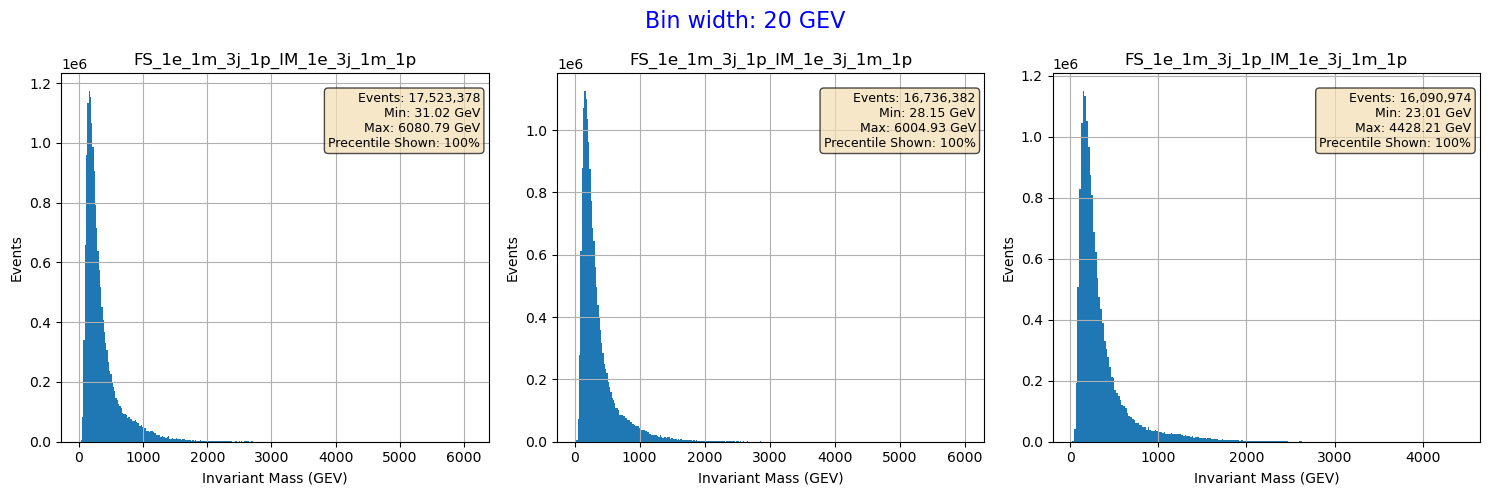

In [ ]:
inv_mass_path = "/storage/agrp/netalev/archive/second_real_run/inv_masses/"
# Properly sort files by size (largest first), get filenames only:

im_arrays_sorted = sorted(
        [file for file in os.listdir(inv_mass_path)],
        key=lambda x: os.path.getsize(os.path.join(inv_mass_path, x)),
        reverse=True
        
    )
    
widths = [1, 3, 5, 10 ,20]
max_arrays = 3

im_arrays_loaded = {}
for im_array_npy in im_arrays_sorted[:max_arrays]:
    im_array = np.load(inv_mass_path + im_array_npy)
    im_arrays_loaded[im_array_npy] = im_array

for bin_width in widths:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # 1 row, 3 columns of subplots
    fig.suptitle(f"Bin width: {bin_width} GEV", fontsize=16, color='blue')
    
    for i, (im_array_npy, im_array) in enumerate(im_arrays_loaded.items()):
        im_array_gev = im_array * 1e-3

        bins = math.ceil(
            (np.max(im_array_gev) - np.min(im_array_gev)) / bin_width
            )  
        # Calculate the 85th percentile as the upper limit for histogram range
        precentile_limit_range = 100
        percentile = np.percentile(im_array_gev, precentile_limit_range)
        hist_range = (np.min(im_array_gev), percentile)
        axes[i].hist(im_array_gev, bins=bins, range=hist_range)
        axes[i].set_xlabel('Invariant Mass (GEV)')
        axes[i].set_ylabel('Events')

        im_array_npy = im_array_npy.split('_')[2:]
        im_array_combination = '_'.join(im_array_npy)
        axes[i].set_title(im_array_combination[:-4])
    
        total_events = len(im_array_gev)
        min_mass = np.min(im_array_gev)
        max_mass = np.max(im_array_gev)
        stats_text = (
            f"Events: {total_events:,}\n"
            f"Min: {min_mass:.2f} GeV\n"
            f"Max: {max_mass:.2f} GeV\n"
            f"Precentile Shown: {precentile_limit_range}%"
        )
        # Place the box in the upper right of the axes
        axes[i].text(
            0.98, 0.95,
            stats_text,
            transform=axes[i].transAxes,
            fontsize=9,
            color="black",
            verticalalignment="top",
            horizontalalignment="right",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.7)
        )
        axes[i].grid(True)

    plt.tight_layout() # Adjust subplot parameters for a tight layout
    plt.show()

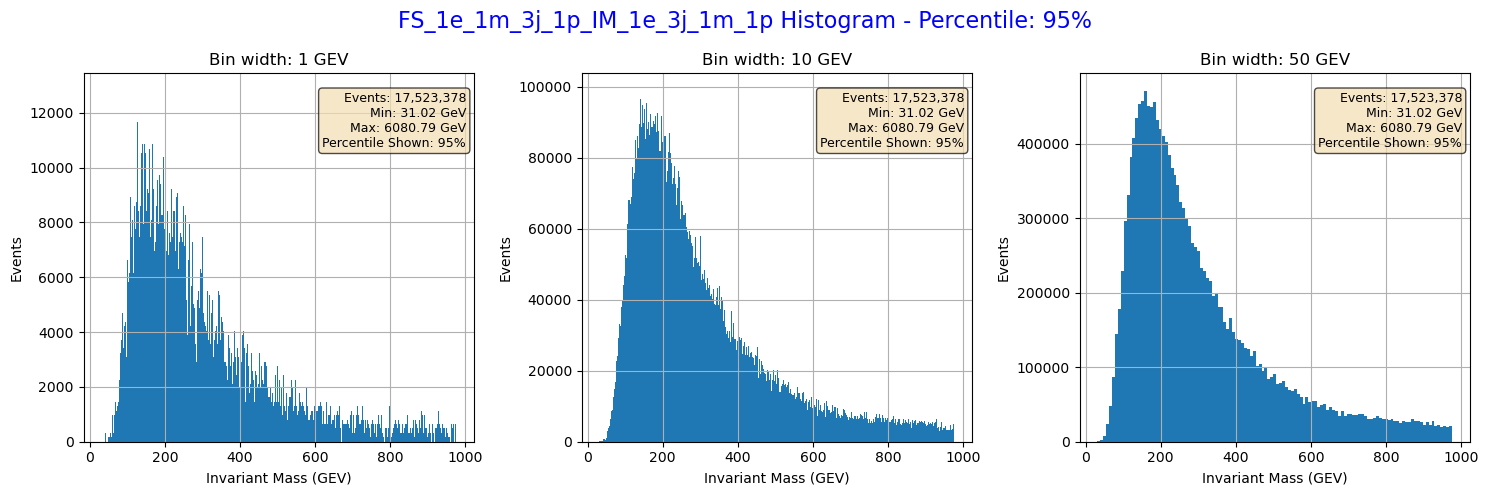

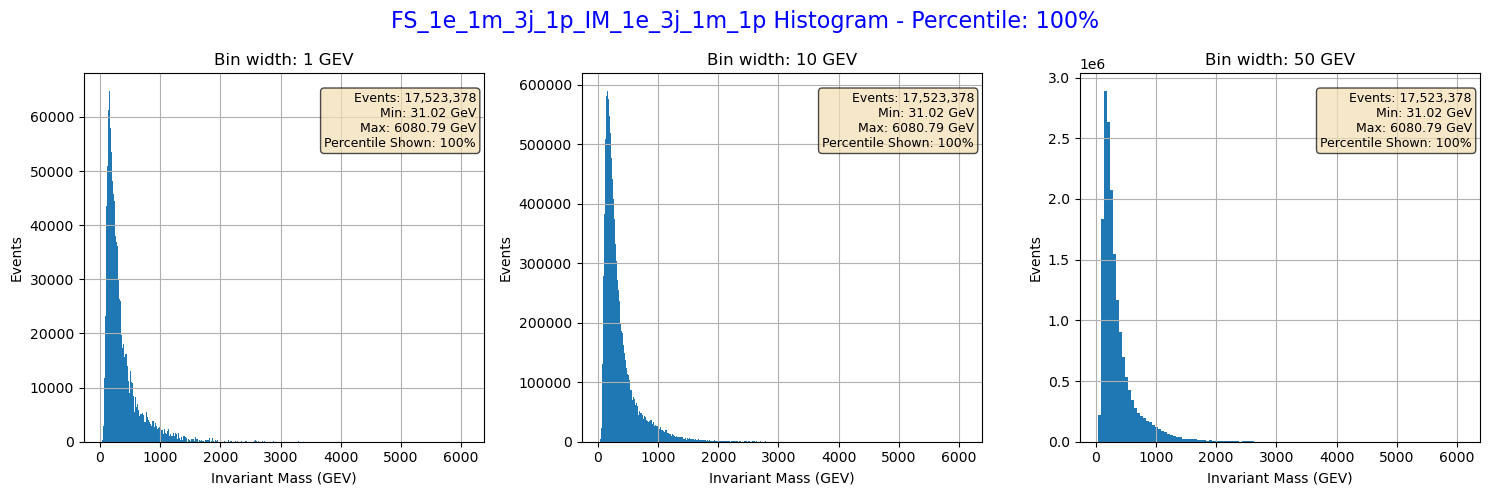

In [ ]:
# Plot only the top histogram with different bin widths and percentiles
top_im_array_npy = im_arrays_sorted[0]
top_im_array = np.load(inv_mass_path + top_im_array_npy)
top_im_array_gev = top_im_array * 1e-3
array_title = top_im_array_npy.split('_')[2:]
array_title = '_'.join(array_title)[:-4]

bin_widths = [1, 10, 50]
percentile_configs = [95, 100]  # 95% and 100% (entirety)

for precentile_limit_range in percentile_configs:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns of subplots
    fig.suptitle(f"{array_title} Histogram - Percentile: {precentile_limit_range}%", fontsize=16, color='blue')
    
    for i, bin_width in enumerate(bin_widths):
        bins = math.ceil(
            (np.max(top_im_array_gev) - np.min(top_im_array_gev)) / bin_width
        )
        
        # Calculate the percentile as the upper limit for histogram range
        percentile = np.percentile(top_im_array_gev, precentile_limit_range)
        hist_range = (np.min(top_im_array_gev), percentile)
        axes[i].hist(top_im_array_gev, bins=bins, range=hist_range)
        axes[i].set_xlabel('Invariant Mass (GEV)')
        axes[i].set_ylabel('Events')
        axes[i].set_title(f"Bin width: {bin_width} GEV")
        
        # Format the title from filename
        im_array_npy_formatted = top_im_array_npy.split('_')[2:]
        im_array_combination = '_'.join(im_array_npy_formatted)
        
        total_events = len(top_im_array_gev)
        min_mass = np.min(top_im_array_gev)
        max_mass = np.max(top_im_array_gev)
        stats_text = (
            f"Events: {total_events:,}\n"
            f"Min: {min_mass:.2f} GeV\n"
            f"Max: {max_mass:.2f} GeV\n"
            f"Percentile Shown: {precentile_limit_range}%"
        )
        # Place the box in the upper right of the axes
        axes[i].text(
            0.98, 0.95,
            stats_text,
            transform=axes[i].transAxes,
            fontsize=9,
            color="black",
            verticalalignment="top",
            horizontalalignment="right",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.7)
        )
        axes[i].grid(True)
    
    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()



In [ ]:

print("loading ROOT")
import ROOT
print("ROOT loaded")

inv_mass_path = "/storage/agrp/netalev/archive/second_real_run/inv_masses/"

im_arrays = [file for file in os.listdir(inv_mass_path)]

print("Loading Sample Array")
# Create a sample ROOT histogram
sample_file = im_arrays[0]
im_array = np.load(os.path.join(inv_mass_path, sample_file))

print("Calculating Number of Bins")
nbins = math.ceil((np.max(im_array) - np.min(im_array)) / bin_width)
print("Calculating Bin Edges")
bin_edges = np.linspace(np.min(im_array), np.max(im_array), nbins + 1)

print("Creating Histogram")
# Create ROOT histogram
hist_name = f"ROI_{Path(sample_file).stem}"
hist = ROOT.TH1F(hist_name, hist_name, len(bin_edges)-1, bin_edges)

print("Filling Histogram")
# Fill histogram
for mass in im_array_gev:
    hist.Fill(mass)
print("Setting Errors")
# Set errors
for i in range(1, len(bin_edges)):
    content = hist.GetBinContent(i)
    hist.SetBinError(i, np.sqrt(content) if content > 0 else 0)

loading ROOT
